In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("http://minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [3]:
# 男性向けメールが配信されたユーザにのみ限定
male_df = df.query(" segment!= 'Womens E-Mail' ").copy()
male_df["treatment"] = (male_df["segment"]=="Mens E-Mail").astype(int)
male_df["history_log"] = np.log(male_df["history"]) # historyの対数変換
male_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,5.796301
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,6.515942
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,6.514816
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,4.621437
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,5.486538


元データの来訪率と購入金額の散布図

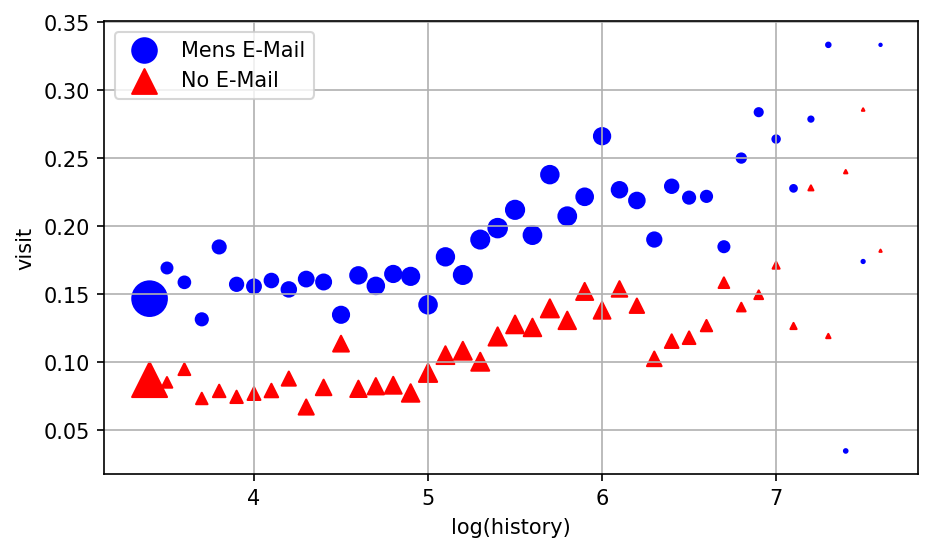

In [4]:
male_df["history_log_grp"] = (male_df["history_log"]/0.1).round(0)*0.1 # history_logの値を0.1ごとに分けてグループ分け
male_df["n"] = 1 # 各グループのデータ数集計用
a = male_df.groupby(["history_log_grp", "segment"]).agg({"visit":"mean", "n":"sum"}).query(" n>10 ")

fig = plt.figure(figsize=(7, 4), dpi=150)
ax = fig.add_subplot(111)
x = a.index.get_level_values("history_log_grp").unique()
y_men_mail = a.xs("Mens E-Mail",level="segment").visit.to_numpy()
y_non_mail = a.xs("No E-Mail",level="segment").visit.to_numpy()
n_men_mail = a.xs("Mens E-Mail",level="segment").n.to_numpy()
n_non_mail = a.xs("No E-Mail",level="segment").n.to_numpy()
ax.scatter(x, y_men_mail, color="blue", label="Mens E-Mail", marker='o', s=n_men_mail/10)
ax.scatter(x, y_non_mail, color="red", label="No E-Mail", marker='^', s=n_non_mail/10)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
plt.legend()
plt.grid()
plt.show()
plt.close()

log(history)が5.5以上にメール配信、という明確なルールに基づいて介入がされているデータの散布図

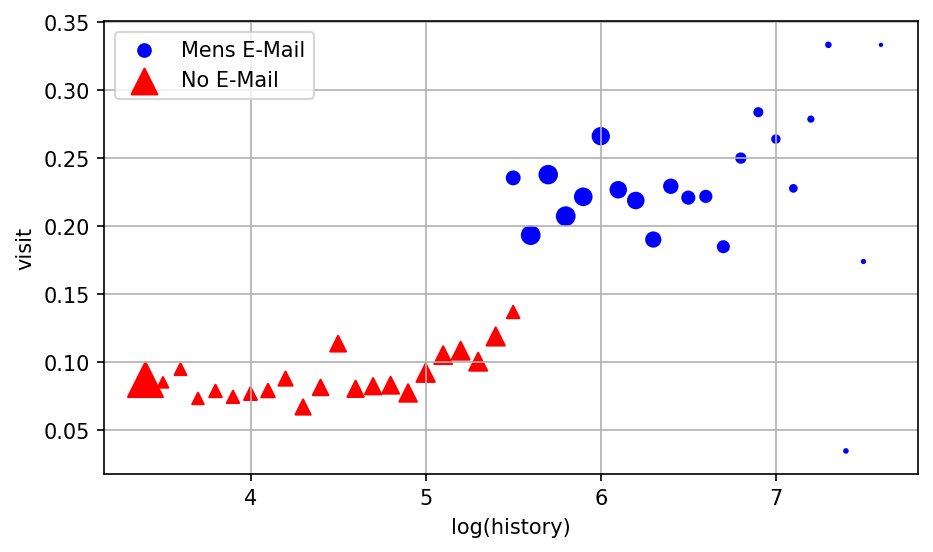

In [5]:
threshold_value = 5.5
rdd_data = male_df.query(" ((history_log>@threshold_value) & (segment=='Mens E-Mail')) | ((history_log<=@threshold_value) & (segment=='No E-Mail')) ")
a = rdd_data.groupby(["history_log_grp", "segment"]).agg({"visit":"mean", "n":"sum"}).query(" n>10 ")

fig = plt.figure(figsize=(7, 4), dpi=150)
ax = fig.add_subplot(111)
x1 = a.xs("Mens E-Mail",level="segment").index
x2 = a.xs("No E-Mail",level="segment").index
y_men_mail = a.xs("Mens E-Mail",level="segment").visit.to_numpy()
y_non_mail = a.xs("No E-Mail",level="segment").visit.to_numpy()
n_men_mail = a.xs("Mens E-Mail",level="segment").n.to_numpy()
n_non_mail = a.xs("No E-Mail",level="segment").n.to_numpy()
ax.scatter(x1, y_men_mail, color="blue", label="Mens E-Mail", marker='o', s=n_men_mail/10)
ax.scatter(x2, y_non_mail, color="red", label="No E-Mail", marker='^', s=n_non_mail/10)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
plt.legend()
plt.grid()
plt.show()
plt.close()

### 集計による分析
- メールを配信した効果で来訪率が13.4%ほど上がったと言える
- しかしhistory_log(購入金額)が明らかに高いユーザにメールを配信したためセレクションバイアスが含まれた効果量

In [6]:
rdd_data.groupby("segment").visit.mean()

segment
Mens E-Mail    0.224002
No E-Mail      0.090694
Name: visit, dtype: float64

### 線形回帰による分析
- 介入の効果量は約0.11、メールを配信することで訪れる人が11%増加することがわかる

In [7]:
y = rdd_data[["visit"]] # 来訪したか
X = rdd_data[["treatment", "history_log"]]
X = sm.add_constant(X)

rdd_lm_reg = sm.OLS(y, X).fit()
rdd_lm_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  visit   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     380.2
Date:                Fri, 19 Aug 2022   Prob (F-statistic):          5.78e-163
Time:                        16:41:33   Log-Likelihood:                -7095.7
No. Observations:               21292   AIC:                         1.420e+04
Df Residuals:                   21289   BIC:                         1.422e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0404      0.016      2.454      0.014       0.008       0.073
treatment       0.1137      0.008     14.240      0.000       0.098       0.129
history_log     0.0114      0.004      3.103      0.002       0.004       0.019
==============================================================================
Omnibus:                     7464.667   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19082.440
Skew:                           2.006   Prob(JB):                         0.00
Kurtosis:                       5.327   Cond. No.                         40.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""